# Reproduction of NPHC experimental results on simulated datasets

In this notebook, we try to reproduce the experiments results of Figure 2 of the NPHC paper.

---

Import libs

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import tick
from tick.hawkes.simulation import SimuHawkesExpKernels, SimuHawkesMulti
from tick.hawkes import HawkesCumulantMatching

/Users/trouleau/miniconda3/envs/mhp-cumulants/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/trouleau/miniconda3/envs/mhp-cumulants/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/trouleau/miniconda3/envs/mhp-cumulants/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/troule

Define helper functions to generate the synthetic datasets

In [2]:
def build_parameters(dim):
    """Define the synthetic parameters as stated in the NPHC paper for dimension `dim`"""
    mu = 0.01
    alpha = 1/10
    beta0 = 1.0
    beta_mult = 10

    dim1 = int(dim * 0.5)
    dim2 = int(dim * 0.3)
    dim3 = int(dim * 0.2)


    mus = mu * np.ones(dim)

    Alpha = np.zeros((dim, dim))
    Alpha[0:dim1, 0:dim1] = alpha * np.triu(np.ones((dim1, dim1)))
    Alpha[dim1:dim1+dim2, dim1:dim1+dim2] = alpha * np.tril(np.ones((dim2, dim2)))
    Alpha[dim1+dim2:dim1+dim2+dim3, dim1+dim2:dim1+dim2+dim3] = alpha * np.triu(np.ones((dim3, dim3)))

    Beta = np.zeros((dim, dim))
    Beta[0:dim1, 0:dim1] = np.triu(np.ones((dim1, dim1))) * beta0
    Beta[dim1:dim1+dim2, dim1:dim1+dim2] = np.tril(np.ones((dim2, dim2))) * beta0 * beta_mult
    Beta[dim1+dim2:dim1+dim2+dim3, dim1+dim2:dim1+dim2+dim3] = np.triu(np.ones((dim3, dim3))) * beta0 * beta_mult * beta_mult
    
    return mus, Alpha, Beta

## 1. Small `Exp10` dataset

Let us first experiment on a smaller 10-dimensional process.

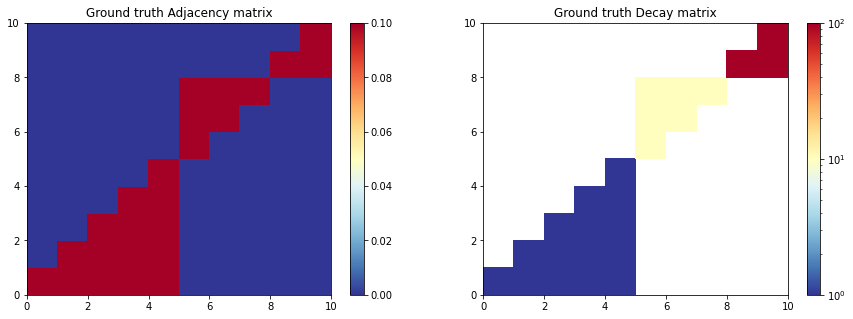

In [3]:
dim = 10
mus, Alpha, Beta = build_parameters(dim)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.sca(axs[0]);
plt.pcolor(Alpha, norm=colors.Normalize(vmin=0.0, vmax=Alpha.max()), cmap='RdYlBu_r');
plt.title('Ground truth Adjacency matrix')
plt.colorbar();
plt.sca(axs[1]);
plt.pcolor(Beta, norm=colors.LogNorm(vmin=Beta[Beta > 0].min(), vmax=Beta.max()), cmap='RdYlBu_r');
plt.title('Ground truth Decay matrix')
plt.colorbar();

Simulate a datasets of `n_realizations` with `max_jumps` per realization

In [4]:
max_jumps_per_node = 1e5              # Average number of jumps to simulate per node
max_jumps = max_jumps_per_node * dim  # Total number of jumps to simulate
n_realizations = 20                   # Number of realizations to simulate

simu_hawkes = SimuHawkesExpKernels(baseline=mus, adjacency=Alpha, decays=Beta, 
                                   max_jumps=max_jumps, verbose=False)
multi = SimuHawkesMulti(simu_hawkes, n_simulations=n_realizations, n_threads=-1)
       
multi.simulate();

Fit the model using NPHC

In [5]:
# Integration support
H = 20

nphc = HawkesCumulantMatching(integration_support=H)
nphc.fit(multi.timestamps)

Instructions for updating:
Colocations handled automatically by placer.


Visualize the results

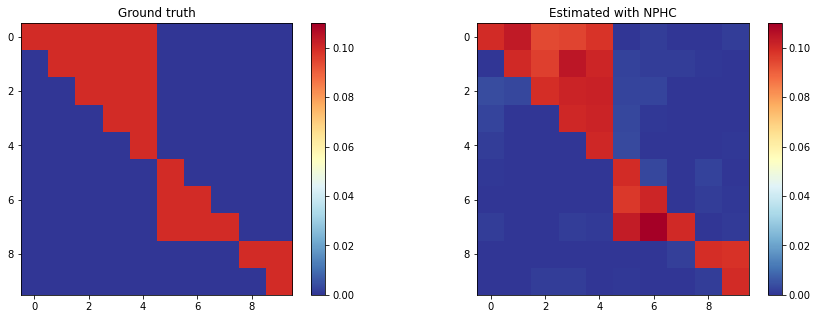

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

vmax = max(Alpha.max(), nphc.adjacency.max())
vmin = min(0.0, Alpha.min(), nphc.adjacency.min())
cnorm = norm=colors.Normalize(vmin=0.0, vmax=vmax)
cmap = 'RdYlBu_r'

plt.sca(axs[0]);
plt.imshow(Alpha, norm=cnorm, cmap=cmap);
plt.title('Ground truth')
plt.colorbar();

plt.sca(axs[1]);
plt.imshow(nphc.adjacency, norm=cnorm, cmap=cmap);
plt.title('Estimated with NPHC')
plt.colorbar();

---

## 2. Larger `Exp100` dataset

A larger dimensional process with $d=100$ with an adjacency matrix that is a block-matrix composed of lower and upper trianguler blocks with constant value.

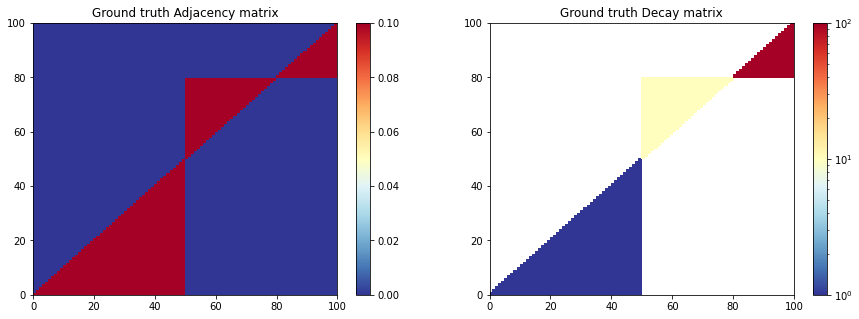

In [7]:
dim = 100
mus, Alpha, Beta = build_parameters(dim)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plt.sca(axs[0]);
plt.pcolor(Alpha, norm=colors.Normalize(vmin=0.0, vmax=Alpha.max()), cmap='RdYlBu_r');
plt.title('Ground truth Adjacency matrix')
plt.colorbar();
plt.sca(axs[1]);
plt.pcolor(Beta, norm=colors.LogNorm(vmin=Beta[Beta > 0].min(), vmax=Beta.max()), cmap='RdYlBu_r');
plt.title('Ground truth Decay matrix')
plt.colorbar();

Simulate a datasets of `n_realizations` with `max_jumps` per realization

In [8]:
max_jumps_per_node = 1e5
max_jumps = max_jumps_per_node * dim
n_realizations = 20

simu_hawkes = SimuHawkesExpKernels(baseline=mus, adjacency=Alpha, decays=Beta, 
                                   max_jumps=max_jumps, verbose=False)
multi = SimuHawkesMulti(simu_hawkes, n_simulations=n_realizations, n_threads=-1)
multi.simulate();

KeyboardInterrupt: 

In [ ]:
# Integration support
H = 20

nphc = HawkesCumulantMatching(integration_support=H)
nphc.fit(multi.timestamps)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(axs[0]);
plt.imshow(Alpha, interpolation='none', 
           norm=colors.Normalize(vmin=0.0, vmax=Alpha.max()), cmap='RdYlBu_r');
plt.title('Ground truth')
plt.colorbar();

plt.sca(axs[1]);
plt.imshow(nphc.adjacency, interpolation='none', 
           norm=colors.Normalize(vmin=nphc.adjacency.min(), 
                                 vmax=nphc.adjacency.max()), cmap='RdYlBu_r');
plt.title('Estimated with NPHC')
plt.colorbar();